# Notebook to develop the model for the project

# List of ideas to improve the network

1. ## Add a grid with finer blocks to the input as transform
2. ## Revise the architecture
3. ## Add dropout to the network
4. ## Find a way to measure accuracy of multiple regression network with some tolerance factor
5. ## List all hyperparameters of the network (affecting net performmance)
    >### Learning rate
    >### number of epochs
    >### batch size
    >### Dropout rate
    >### Loss function
    >### Optimmizer
    >### Network architecture
    - CNN layers NofElement, arrangment, and parameters
    
    - FC layers NofElement, arrangment, and parameters
6. ## Augment the dataset with transforms to more than 10^5 sample, insure dataset is statistically sound (no extreme bias, etc...)
7. ## Use a genetic algorithm to search best set of hyper parameters 
    >### Encode all hyperparameters listed into a string represention "chromosome/gene"
    >### Use the new measure of accuracy to gauge the "fitness" of the net
    >### Design a function to allow for "crossover" between nets' genes 
    >### Design a "mutation" function that allows for variations in hyperparameters.
    >### Put the environment together to run the algorithm
7. ## Investigate if autoencoders might performe better   

In [1]:
# All our imports
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
import PIL
import os

#for all the plots to be inline
%matplotlib inline 


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.values[index][0]
        labels = np.array([1, 1, 1, 1, 1, 1, 1, 1])
        for x in range(0, 8):
            labels[x] = self.df.values[index][x+1]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, labels


cuda:0


In [ ]:
# Select device to train on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = 'cpu'

In [4]:
'''Data Set manipulation'''
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

root = "C:\\Users\\the_3\\Desktop"
trainDataset = CustomDataset(root + "\\poly-curve-detector\\data\\plotData\\labels\\trainPlots.csv",
                               root + "\\poly-curve-detector\\data\\plotData\\trainPlots", transform)

testDataset = CustomDataset(root + "\\poly-curve-detector\\data\\plotData\\labels\\testPlots.csv",
                               root + "\\poly-curve-detector\\data\\plotData\\testPlots", transform)

#print first label in each dataset
#labels in order [a1,a2,a3,a4,a5,a6,a7,a8]
# image, labels = trainDataset[0]
# print(labels[0:9])
# image, labels = testDataset[0]
# print(labels[0:9])

In [5]:
train_set = torch.utils.data.DataLoader(trainDataset, shuffle=True, batch_size=128)
test_set = torch.utils.data.DataLoader(testDataset, shuffle=False, batch_size=128)

torch.Size([128, 1, 96, 96]) torch.Size([128, 8])
Train Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]]])
Labels: tensor([ 8, -5,  8, -2, -5,  5,  4,  3], dtype=torch.int32)

torch.Size([1, 96, 96]) torch.Size([8])


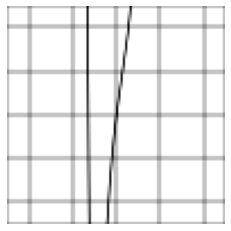

torch.Size([128, 1, 96, 96]) torch.Size([128, 8])
Test Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]]])
Labels: tensor([  5, -10,  -4,   3,  -7,   7,  -9,  -7], dtype=torch.int32)

torch.Size([1, 96, 96]) torch.Size([8])


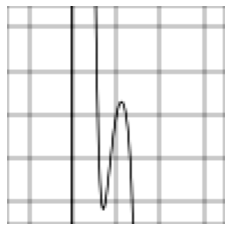

In [6]:
#one way to see batch size
train_batch = next(iter(train_set))
img, lbls = train_batch
print(img.shape, lbls.shape)

#display the first image in train_set
#note: image changes each time run because shuffle is set to true
for images, labels in train_set:
    image, label = images[0], labels[0]
    print(f"Train Set 0\nImage: {image}\nLabels: {label}\n")
    print(image.shape, label.shape)
    figure = plt.figure(figsize=(4,4))
    figure.add_subplot()
    plt.axis("off")
    plt.imshow(image.permute(1,2,0), cmap="gray")
    plt.show()
    break
    
#test batch size
test_batch = next(iter(test_set))
img, lbls = test_batch
print(img.shape, lbls.shape)

#display the first image in test_set
for images, labels in test_set:
    image, label = images[0], labels[0]
    print(f"Test Set 0\nImage: {image}\nLabels: {label}\n")
    print(image.shape, label.shape)
    figure = plt.figure(figsize=(4,4))
    figure.add_subplot()
    plt.axis("off")
    plt.imshow(image.permute(1,2,0), cmap="gray")
    plt.show()
    break

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # more analysis required to determine the specifics of the architecture
       
        self.n_output = 8
        self.n_channel = 1
    
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, 8, 3), # convolution2dLayer(3,8,'Padding','same')
                nn.BatchNorm2d(8),   # batchNormalizationLayer
                nn.LeakyReLU(), # reluLayer
                nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
                nn.Conv2d(8, 16, 3), # convolution2dLayer(3,16,'Padding','same')
                nn.BatchNorm2d(16), # batchNormalizationLayer
                nn.LeakyReLU(), # reluLayer
                nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
                nn.Conv2d(16, 32, 3), # convolution2dLayer(3,32,'Padding','same')
                nn.BatchNorm2d(32), # batchNormalizationLayer
                nn.LeakyReLU(), # reluLayer
                nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
                nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
                nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
                nn.BatchNorm2d(32), # batchNormalizationLayer
                nn.LeakyReLU(), # reluLayer
                nn.MaxPool2d(2, 2) # Max pooling layer
        )

        self.n_input = 1568 # the output of maxpool 96*96 
        #TODO:actual value might be determined from the computed output of the cnn layers
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

        self.fc_layers = nn.Sequential(
#         fullyConnectedLayer(1)
                nn.Linear(self.n_input,  4096),
                nn.LeakyReLU(),
                nn.Linear(4096, 4096),
                nn.LeakyReLU(),
                nn.Linear(4096, 128),
                nn.LeakyReLU(),
                nn.Linear(128, 64),
                nn.LeakyReLU(),
                nn.Linear(64, self.n_output),
                nn.LeakyReLU()
        )


#         regressionLayer
        self.criterion = nn.MSELoss()       
#         dropoutLayer(0.2)
        self.dropout =  nn.Dropout(p=0.2)
        

        
    def forward(self, x):
        #feedword pass through our network
        x = self.cnn_layers(x)
        x = x.view(x.shape[0], -1) #flatten the input tensor
        x = self.fc_layers(x)
        
        return x


    @staticmethod
    def load_checkpoint(new_model, filepath):
        checkpoint = torch.load(filepath)
        # model = Network(
        #         checkpoint['input_size'], 
        #         checkpoint['output_size'],
        #         # checkpoint['cnn_layers'],
        #         # checkpoint['fc_layers']
        # )
        new_model.load_state_dict(checkpoint['state_dict'])
        return new_model
    
    def save(self, dirpath):
        self.checkpoint = {
        #     'input_size': self.n_input, 
        #     'output_size': self.n_output,
        #     'cnn_layers': [each. for each in model.cnn_layers],
        #     'fc_layers': [each.out_features for each in model.fc_layers],
            'state_dict': model.state_dict()
        }
        torch.save(self.checkpoint, f'{dirpath}\\model_checkpoint.pth')
    


In [8]:
    
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:
        # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
        # images = images.view(images.shape[0], -1)
        labels = labels.float()
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        # print(f'output={output.shape}')
        # print(f'label={labels.shape}')
        test_loss += criterion(output, labels)

        # Calculate accuracy
        # ps = torch.exp(output)
        # top_p, top_class = ps.topk(1, dim=1)
        # equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        # accuracy += 1 - test_loss
        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        # ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        # equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        # accuracy += equality.type_as(torch.FloatTensor()).mean()
        # accuracy = r2_score(labels, output)   # r2_score is the scikit learn r2 score function.
        # print("accuracy = ", accuracy)   # here i get wierd values and it doesn't get better over time, in contrast the loss decreased over time

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):

    steps = 0
    running_loss = 0
    test_losses = []
    train_losses = []
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
            # Flatten images into a 784 long vector
            # images = images.view(images.shape[0], -1)
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            output = model.forward(images)
            # print(f'output={output.shape}')
            # print(f'label={labels.shape}')
            loss = criterion(output, labels)
            loss.backward() # computes gradient and backpropagation
            optimizer.step() # update of weights and biases happenss
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                    #   "Test Accuracy: {:.3f}".format(accuracy/len(testloader))
                      )
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()
    plt.xlim([0, 100])          
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)

In [12]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.005)

model.to(device)

train(
    model=model, 
    trainloader=train_set, 
    testloader=test_set, 
    criterion=model.criterion, 
    optimizer=optimizer, 
    epochs=10000, 
    print_every=100)


Epoch: 12/10000..  Training Loss: 39.563..  Test Loss: 32.985.. 
Epoch: 23/10000..  Training Loss: 31.408..  Test Loss: 32.461.. 
Epoch: 34/10000..  Training Loss: 28.673..  Test Loss: 29.115.. 
Epoch: 45/10000..  Training Loss: 27.087..  Test Loss: 29.756.. 
Epoch: 56/10000..  Training Loss: 25.577..  Test Loss: 28.790.. 
Epoch: 67/10000..  Training Loss: 24.884..  Test Loss: 35.068.. 
Epoch: 78/10000..  Training Loss: 23.337..  Test Loss: 25.017.. 
Epoch: 89/10000..  Training Loss: 22.851..  Test Loss: 31.399.. 
Epoch: 100/10000..  Training Loss: 21.198..  Test Loss: 24.662.. 
Epoch: 112/10000..  Training Loss: 19.894..  Test Loss: 23.555.. 
Epoch: 123/10000..  Training Loss: 18.745..  Test Loss: 22.413.. 
Epoch: 134/10000..  Training Loss: 17.357..  Test Loss: 29.906.. 
Epoch: 145/10000..  Training Loss: 17.166..  Test Loss: 22.436.. 
Epoch: 156/10000..  Training Loss: 16.325..  Test Loss: 21.181.. 
Epoch: 167/10000..  Training Loss: 15.618..  Test Loss: 26.324.. 
Epoch: 178/10000..

In [ ]:
test_batch = next(iter(test_set))
img, lbls = test_batch
img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

output = model.forward(img)
print(output)
print(lbls)

tensor([[ 5.2008, -9.6824, -5.7073,  ...,  7.1544, -3.5886, -0.6744],
        [-5.2907, -1.7381, -4.6693,  ..., -6.8853,  4.3071, -3.6909],
        [-7.2411,  5.6466, -3.8650,  ...,  3.2651,  4.0605, -2.2999],
        ...,
        [ 2.3048,  4.8132,  0.8749,  ...,  3.8693, -6.5397,  2.2766],
        [-9.2177,  1.0919, -3.6577,  ..., -3.3774,  3.8541, -6.0546],
        [ 7.6002, -2.6192, -6.8091,  ...,  5.8757, -4.1277,  7.1936]],
       device='cuda:0', grad_fn=<LeakyReluBackward0>)
tensor([[  5, -10,  -4,  ...,   7,  -9,  -7],
        [ -5,  -2,  -6,  ...,  -4,   8,  -9],
        [ -9,   9,   0,  ...,  -8,   6, -10],
        ...,
        [  2,   4,   3,  ...,   9, -10,  -1],
        [-10,   0,  -5,  ...,   4,  -8, -10],
        [  8,  -1,  -5,  ...,   8,  -4,   3]], device='cuda:0',
       dtype=torch.int32)


In [ ]:
# Save the network
model.save('C:\\Users\\the_3\\Desktop\\poly-curve-detector\\Model')

In [ ]:
# laod network from save
new_model = Network()
Network.load_checkpoint(new_model, "C:\\Users\\the_3\\Desktop\\poly-curve-detector\\Model\\model_checkpoint.pth")

Network(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

In [ ]:
# loaded network from save
test_batch = next(iter(test_set))
img, lbls = test_batch
# img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

output = new_model.forward(img)
print(output)
print(lbls)

tensor([[ 5.2008, -9.6824, -5.7073,  ...,  7.1544, -3.5886, -0.6744],
        [-5.2907, -1.7381, -4.6693,  ..., -6.8853,  4.3071, -3.6909],
        [-7.2411,  5.6466, -3.8649,  ...,  3.2651,  4.0605, -2.2999],
        ...,
        [ 2.3048,  4.8132,  0.8749,  ...,  3.8693, -6.5397,  2.2766],
        [-9.2177,  1.0919, -3.6577,  ..., -3.3774,  3.8541, -6.0546],
        [ 7.6002, -2.6192, -6.8090,  ...,  5.8757, -4.1277,  7.1936]],
       grad_fn=<LeakyReluBackward0>)
tensor([[  5, -10,  -4,  ...,   7,  -9,  -7],
        [ -5,  -2,  -6,  ...,  -4,   8,  -9],
        [ -9,   9,   0,  ...,  -8,   6, -10],
        ...,
        [  2,   4,   3,  ...,   9, -10,  -1],
        [-10,   0,  -5,  ...,   4,  -8, -10],
        [  8,  -1,  -5,  ...,   8,  -4,   3]], dtype=torch.int32)
